In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Initialize session
sess = tf.Session()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load data
mcycle = pd.read_csv('mcycle',delimiter='\t')
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

# Reshape to input format for network
times = np.expand_dims(mcycle.times.values, 1)
accel = np.expand_dims(mcycle.accel.values, 1)
times.shape, accel.shape

((94, 1), (94, 1))

In [3]:
# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles, 
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        self.optim = tf.train.AdamOptimizer()
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))

            self.layer0 = tf.layers.dense(self.x, 
                                    units=32, 
                                    activation=tf.nn.relu)
            self.layer1 = tf.layers.dense(self.layer0, 
                                    units=32, 
                                    activation=tf.nn.relu)

            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]
                
                # Get output layers 
                output = tf.layers.dense(self.layer1, 1, name="{}_q{}".format(i, int(q*100)))
                self.outputs.append(output)
                
                # Create losses
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error), axis=-1)

                self.losses.append(loss)

            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = self.optim.minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):  
        for epoch in range(epochs):
            epoch_losses = []
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]),:]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]),:]

                feed_dict = {self.x: batch_x,
                             self.y: batch_y}

                _, c_loss = self.sess.run([self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 100 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x):   
        # Run model to get outputs
        feed_dict = {self.x: x}
        predictions = sess.run(self.outputs, feed_dict)
        
        return predictions

In [4]:
# Instantiate model
quantiles = [.1, .5, .9]
model = q_model(sess, quantiles, batch_size=32)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [5]:
# Run training
epochs = 2000
model.fit(times, accel, epochs)

Epoch 0: 0.9869703650474548
Epoch 100: 0.5274757742881775
Epoch 200: 0.3774557113647461
Epoch 300: 0.311544805765152
Epoch 400: 0.27597999572753906
Epoch 500: 0.2658614218235016
Epoch 600: 0.2577192485332489
Epoch 700: 0.25364142656326294
Epoch 800: 0.2512976825237274
Epoch 900: 0.2500403821468353
Epoch 1000: 0.250719279050827
Epoch 1100: 0.24685299396514893
Epoch 1200: 0.2459111213684082
Epoch 1300: 0.24352653324604034
Epoch 1400: 0.24375982582569122
Epoch 1500: 0.2409871369600296
Epoch 1600: 0.2410934716463089
Epoch 1700: 0.2435447722673416
Epoch 1800: 0.23995591700077057
Epoch 1900: 0.23951363563537598


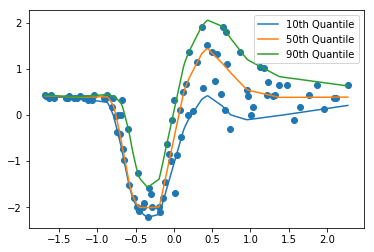

In [6]:
# Generate the range of data we'd like to predict
test_times = np.expand_dims(np.linspace(times.min(),times.max(),200), 1)
predictions = model.predict(test_times)

plt.scatter(times, accel)
for i, prediction in enumerate(predictions):
    plt.plot(test_times, prediction, label='{}th Quantile'.format(int(model.quantiles[i]*100)))
    
plt.legend()
plt.show()

In [7]:
predictions = model.predict(times)
np.mean(predictions[0]), np.mean(predictions[1]), np.mean(predictions[2])

(-0.38626337, -0.006839947, 0.46308112)

In [8]:
in_the_range = np.sum((accel >= predictions[0]) & (accel <= predictions[2]))
print("Percentage in the range (expecting 80%):", in_the_range / len(times))

Percentage in the range (expecting 80%): 0.7127659574468085


In [9]:
out_of_the_range = np.sum((accel < predictions[0]) | (accel > predictions[2]))
print("Percentage out of the range (expecting 20%):", out_of_the_range / len(times))

Percentage out of the range (expecting 20%): 0.2872340425531915
